In [2]:
import os
import shutil
import sagemaker.amazon.common as smac    
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3


In [3]:
#Navidate to deep-ar directory to install the deepar package containing commonly used functions
!pip install setuptools==65.6.0

path = ".."
os.chdir(path)

In [4]:
#install predefined functions
!pip install .

#Navigate to the parent directory to train the DeepAR model
# org_path = ".."
# os.chdir(org_path)

!pwd

Processing /home/ec2-user/SageMaker
  Preparing metadata (setup.py) ... done
  Created wheel for deepar: filename=deepar-0.0.0-py3-none-any.whl size=3462 sha256=33cfb035b7c31629d56b7d63e022bcbdf1ec5d25175b89b4c9ffb822c0cace46
  Stored in directory: /tmp/pip-ephem-wheel-cache-fai9e7mg/wheels/79/a2/86/f30415f29cd2ece5ccbccf03b1ed8d9cb848afeabedfec49df
Successfully built deepar
  Attempting uninstall: deepar
    Found existing installation: deepar 0.0.0
    Uninstalling deepar-0.0.0:
      Successfully uninstalled deepar-0.0.0
/home/ec2-user/SageMaker


In [5]:
import deepar as da

# Train Model

In [6]:
train_key = 'deepar_sales_training.json'
test_key = 'deepar_sales_test.json'
# Prediction and context length for training the DeepAR model
prediction_length = 9

salesfn = './data/store20_sales.csv'
salesdf = da.retailsales.prepareSalesData(salesfn)
testSet = da.retailsales.getTestSales(salesdf, test_key)
trainingSet = da.retailsales.getTrainSales(salesdf, train_key, prediction_length)

In [7]:
bucket         = 'ai620-teagans'
prefix         = 'deepar-weekly-sales'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

sagemaker_session = sagemaker.Session()

train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

In [8]:
role = get_execution_role()
output_path = r's3://{0}/{1}'.format(bucket, output_prefix) 

container = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

deepAR = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=1,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sagemaker_session)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Define Hyperparameters

In [9]:
hyperparameters = {
    "time_freq": 'W', # weekly series
    "context_length": prediction_length, # how many data points are we going to look at before predicting
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40", # of cells to use in each of the hidden layers
    "num_layers": "2", # of hidden layers
    "likelihood": "gaussian",
    "epochs": "300", # max number of passses over the training data
    "mini_batch_size": "32", # size of the mini batches used during training
    "learning_rate": "0.00001",
    "dropout_rate": "0.05", #for each iteration, a random subset of hidden neurons are not updated
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

deepAR.set_hyperparameters(**hyperparameters) #** = arbitrary number of arguments to functions

In [10]:
data_channels = {"train": train_path, "test": test_path}
deepAR.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2024-12-10-03-49-00-193


2024-12-10 03:49:02 Starting - Starting the training job...
2024-12-10 03:49:15 Starting - Preparing the instances for training...
2024-12-10 03:49:58 Downloading - Downloading the training image.....................
2024-12-10 03:53:25 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/10/2024 03:53:37 INFO 140083293493056] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.0

## PE09-3 Predict & Evaluate Sales

In [11]:
deepAR_predictor = deepAR.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: forecasting-deepar-2024-12-10-04-00-51-992
INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-2024-12-10-04-00-51-992
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2024-12-10-04-00-51-992


-----------!

Predicted Sales:  [39330.79296875, 51159.421875, 35531.87890625, 33803.34765625, 45958.828125, 55291.38671875, 61247.90625, 45583.43359375, 61722.953125]
Actual Sales:  [100422.86, 94987.08, 90889.75, 115695.71, 100372.02, 96616.19, 93460.57, 99398.64, 105059.88]


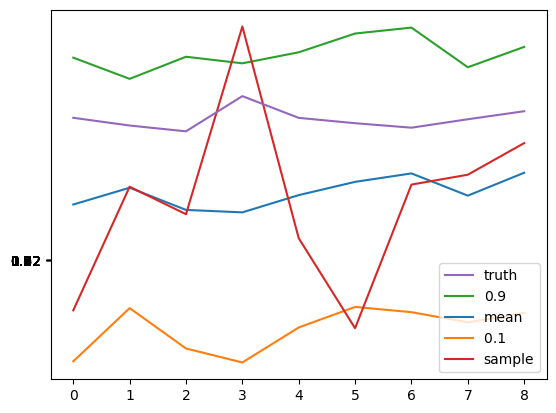

In [12]:
#Predict last 9 weeks of a department and compare to ground truth

deepAR_predictor.content_type = 'application/json'
dept = 90 

prediction_data = da.salesinference.buildInferenceData(dept, trainingSet, testSet)
#print(prediction_data)

result = deepAR_predictor.predict(prediction_data)

y_mean, y_q1, y_q2, y_sample = da.salesinference.getInferenceSeries(result)
print("Predicted Sales: ", y_mean)
print("Actual Sales: ", list(testSet[dept]['Weekly_Sales'][134:]))

da.salesinference.plotResults(prediction_length, result, truth=True, truth_data=testSet[dept]['Weekly_Sales'][134:], truth_label='truth')